# Práctica 1

Práctica realizada por: Samuel Juárez, Alejandra Lorenzana, Iker Rodríguez y Raúl Vara

## Clasificador 1

In [133]:
# importar las librerías necesarias
import os
import itertools
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping



## Definición del directorio de trabajo y los directorios de los datos

In [134]:
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [135]:
# definir los parámetros de la red convolucional
input_shape = (150, 150, 3)
num_classes = 2
learning_rate = 0.001
batch_size = 32
epochs = 10
#batch_size = 20
#epochs = 50

IMG_WIDTH = 150
IMG_HEIGHT = 150

# Clasificación 1: Pneumonia vs Normal
CLASS_NAMES = ['Normal', 'Pneumonia']

# crear generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



## División de los datos en Datasets

### Train dataset

In [136]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 2682 images belonging to 2 classes.


### Validation Dataset

In [137]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 16 images belonging to 2 classes.


### Test Datset

In [138]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 624 images belonging to 2 classes.


## Arquitectura de la red

In [139]:
# definir la arquitectura de la red
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


## Compilación del modelo

In [140]:
# compilar el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=categorical_crossentropy,
              metrics=['accuracy'])


## Entrenamiento del modelo

In [141]:
# Crear el callback EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=5, min_delta=0.0, mode='min', baseline=0.2, restore_best_weights=True)

# Entrenar el modelo con el callback EarlyStopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/10
84/84 [==============================] - 100s 1s/step - loss: 0.5081 - accuracy: 0.7248 - val_loss: 0.6841 - val_accuracy: 0.6250
Epoch 2/10
84/84 [==============================] - 82s 974ms/step - loss: 0.2896 - accuracy: 0.8762 - val_loss: 0.5283 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 86s 1s/step - loss: 0.2301 - accuracy: 0.9131 - val_loss: 0.3184 - val_accuracy: 0.8125
Epoch 4/10
84/84 [==============================] - 91s 1s/step - loss: 0.2140 - accuracy: 0.9150 - val_loss: 0.3452 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 109s 1s/step - loss: 0.2087 - accuracy: 0.9154 - val_loss: 0.4068 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 100s 1s/step - loss: 0.1786 - accuracy: 0.9348 - val_loss: 0.3055 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 100s 1s/step - loss: 0.1720 - accuracy: 0.9351 - val_loss: 0.3100 - val_accuracy: 0.8125
Epoch 8/10
84

In [142]:
# Definir el callback de EarlyStopping
#early_stop = EarlyStopping(monitor='loss', patience=3, min_delta=0, verbose=1)

# Entrenar el modelo con el callback de EarlyStopping y el número de épocas alto
#history = model.fit(train_generator,
#                    epochs=epochs,
#                    validation_data=val_generator,
#                    callbacks=[early_stop])

## Evaluación del modelo en el conjunto de prueba

In [156]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

20/20 [==============================] - 12s 594ms/step - loss: 0.2715 - accuracy: 0.8958
Test accuracy: 0.8958333134651184


## Predicciones del modelo en el conjunto de prueba

In [157]:
# Hacer predicciones en el conjunto de prueba
test_pred = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred, axis=1)

# Calcular el porcentaje de aciertos
correct_pred = np.sum(test_pred_labels == test_generator.classes)
total_pred = len(test_generator.classes)
accuracy = correct_pred / total_pred * 100

print('Test prediction: {:.2f}%'.format(accuracy))


20/20 [==============================] - 7s 333ms/step
Test prediction: 54.01%


## Matriz de confusión

In [158]:
# imprimir la matriz de confusión
test_true_labels = test_generator.classes
cm = confusion_matrix(test_true_labels, test_pred_labels)

print('Matriz de confusión:')
print(cm)

Matriz de confusión:
[[ 72 162]
 [125 265]]


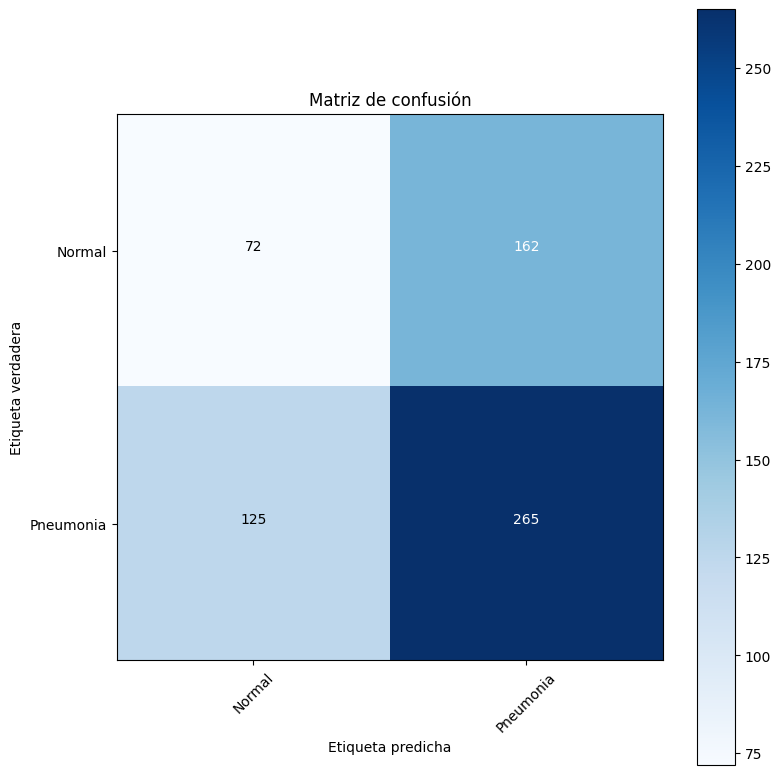

In [159]:
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.colorbar()
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
plt.yticks(tick_marks, CLASS_NAMES)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    

plt.tight_layout()
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.show()

## Evaluación del modelo

### Test Dataset

In [160]:
# Evaluamos el modelo con los datos del conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


20/20 [==============================] - 7s 326ms/step - loss: 0.2715 - accuracy: 0.8958
Test accuracy: 0.8958333134651184


### Validation Dataset

In [161]:
# Evaluamos el modelo con los datos del conjunto de test
val_loss, val_acc = model.evaluate(val_generator)
print('Validation accuracy:', val_acc)

1/1 [==============================] - 0s 239ms/step - loss: 0.3148 - accuracy: 0.8750
Validation accuracy: 0.875


Text(0.5, 1.0, 'Evolución de precisión')

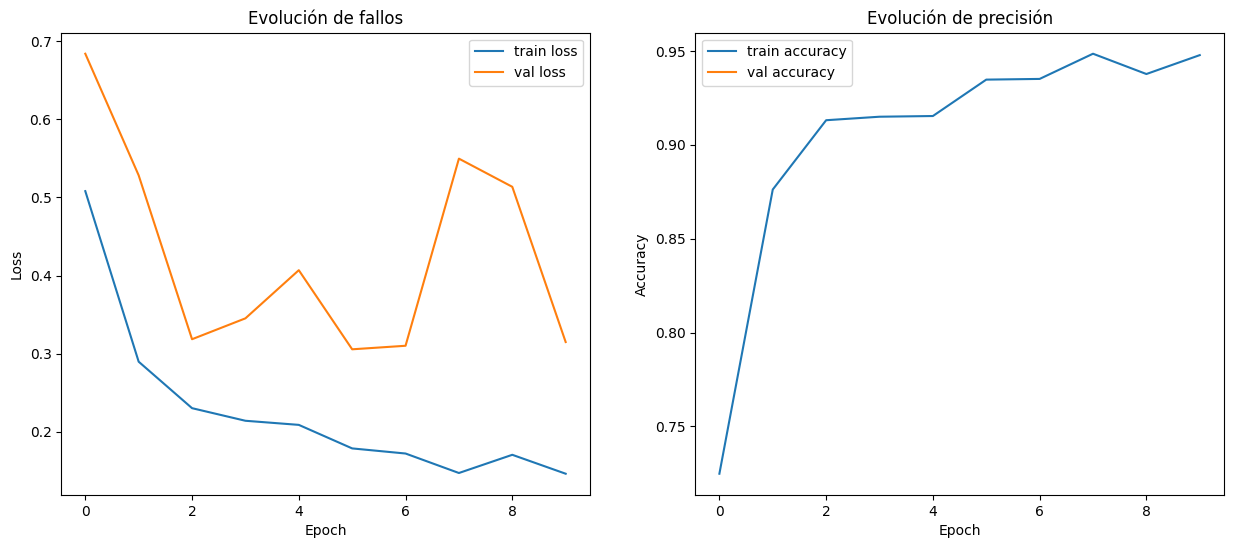

In [163]:
import matplotlib.pyplot as plt

# Obtener los valores de pérdida y precisión del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(train_loss, label='train loss')
ax[0].plot(val_loss, label='val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Evolución de fallos')

ax[1].plot(train_acc, label='train accuracy')
ax[1].plot(val_acc, label='val accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Evolución de precisión')

## Validación del modelo

In [152]:
def predict_image(img_path, prediction):

    # Cargamos la imagen
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Convertimos el arreglo de predicciones a una etiqueta de texto
    label = CLASS_NAMES[np.argmax(prediction)]
    
    # Mostramos la imagen con la etiqueta de predicción
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

    # Convertimos la imagen a un array de numpy
    img_array = img_to_array(img)
    
    # Añadimos una dimensión extra al array para que tenga forma (1, IMG_HEIGHT, IMG_WIDTH, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocesamos la imagen dividiendo cada pixel entre 255
    img_array = img_array / 255.0
    
    # Predecimos la categoría de la imagen
    predictions = model.predict(img_array)
    
    # Imprimimos las probabilidades de pertenencia a cada posible categoría
    print('Probabilidades:')
    for i in range(len(CLASS_NAMES)):
        print('{}: {:.2f}%'.format(CLASS_NAMES[i], predictions[0][i]*100))
    
    # Imprimimos la categoría más probable
    predicted_class = np.argmax(predictions[0])
    print('Predicción:', CLASS_NAMES[predicted_class])


In [153]:
def predict_folder(folder_path):
    # Obtener la lista de nombres de archivo de la carpeta
    filenames = os.listdir(folder_path)

    for filename in filenames:
        # Obtener la ruta completa del archivo de imagen
        img_path = os.path.join(folder_path, filename)

        # Cargar la imagen como un arreglo numpy
        img_array = img_to_array(load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)))

        # Añadir una dimensión extra para que tenga forma (1, IMG_HEIGHT, IMG_WIDTH, 3)
        img_array = np.expand_dims(img_array, axis=0)

        # Preprocesar la imagen dividiendo cada pixel entre 255
        img_array = img_array / 255.0

        # Predecir la categoría de la imagen y mostrar la etiqueta
        prediction = model.predict(img_array)
        predict_image(img_path, prediction)



1/1 [==============================] - 0s 36ms/step


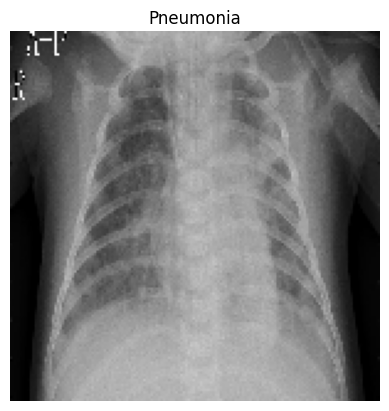

1/1 [==============================] - 0s 34ms/step
Probabilidades:
Normal: 0.16%
Pneumonia: 99.84%
Predicción: Pneumonia
1/1 [==============================] - 0s 39ms/step


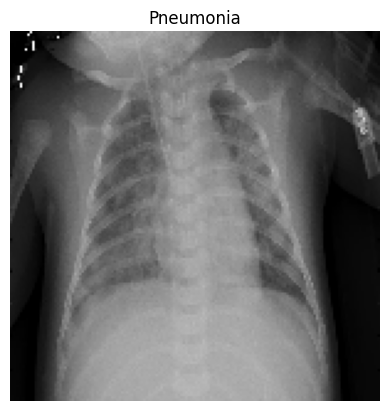

1/1 [==============================] - 0s 33ms/step
Probabilidades:
Normal: 1.42%
Pneumonia: 98.58%
Predicción: Pneumonia
1/1 [==============================] - 0s 83ms/step


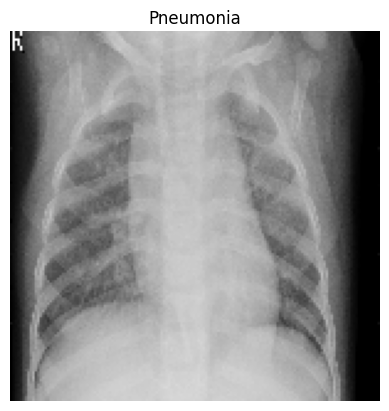

1/1 [==============================] - 0s 40ms/step
Probabilidades:
Normal: 2.15%
Pneumonia: 97.85%
Predicción: Pneumonia
1/1 [==============================] - 0s 49ms/step


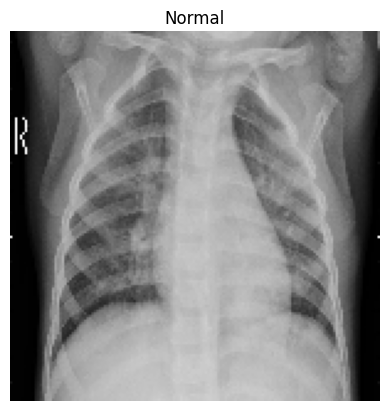

1/1 [==============================] - 0s 42ms/step
Probabilidades:
Normal: 83.39%
Pneumonia: 16.61%
Predicción: Normal
1/1 [==============================] - 0s 31ms/step


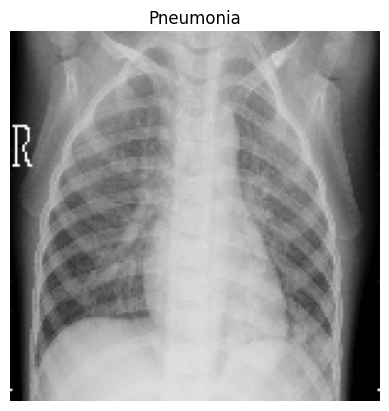

1/1 [==============================] - 0s 41ms/step
Probabilidades:
Normal: 46.04%
Pneumonia: 53.96%
Predicción: Pneumonia
1/1 [==============================] - 0s 39ms/step


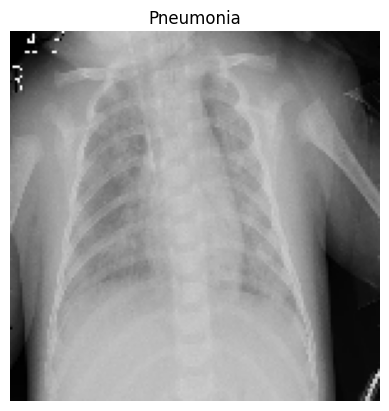

1/1 [==============================] - 0s 37ms/step
Probabilidades:
Normal: 0.42%
Pneumonia: 99.58%
Predicción: Pneumonia
1/1 [==============================] - 0s 32ms/step


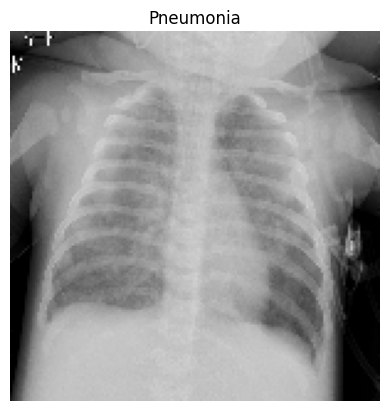

1/1 [==============================] - 0s 49ms/step
Probabilidades:
Normal: 4.34%
Pneumonia: 95.66%
Predicción: Pneumonia
1/1 [==============================] - 0s 37ms/step


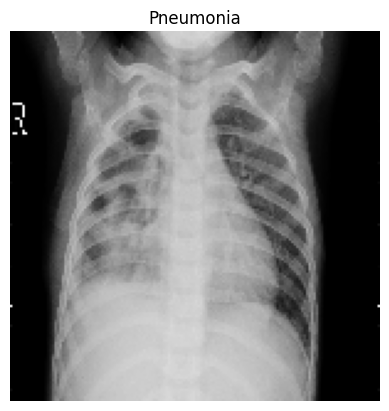

1/1 [==============================] - 0s 40ms/step
Probabilidades:
Normal: 21.20%
Pneumonia: 78.80%
Predicción: Pneumonia


In [164]:
folder_path = './chest_xray/val/PNEUMONIA/'
predict_folder(folder_path)

1/1 [==============================] - 0s 30ms/step


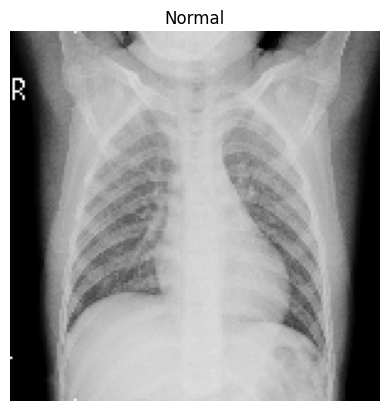

1/1 [==============================] - 0s 33ms/step
Probabilidades:
Normal: 98.34%
Pneumonia: 1.66%
Predicción: Normal
1/1 [==============================] - 0s 31ms/step


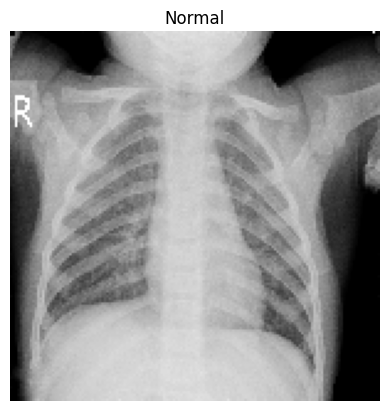

1/1 [==============================] - 0s 33ms/step
Probabilidades:
Normal: 95.94%
Pneumonia: 4.06%
Predicción: Normal
1/1 [==============================] - 0s 36ms/step


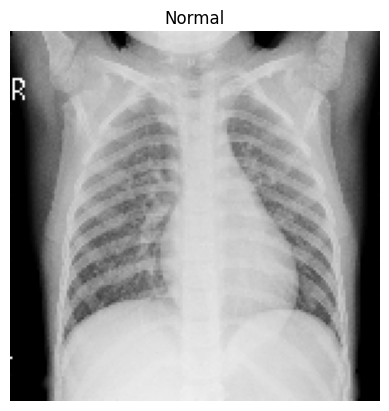

1/1 [==============================] - 0s 32ms/step
Probabilidades:
Normal: 99.28%
Pneumonia: 0.72%
Predicción: Normal
1/1 [==============================] - 0s 30ms/step


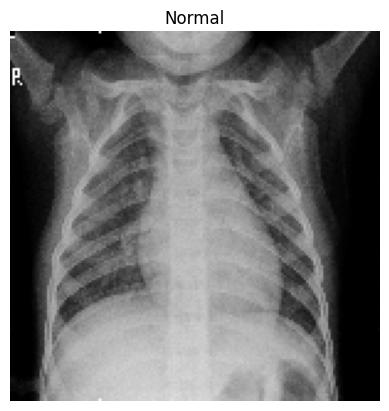

1/1 [==============================] - 0s 31ms/step
Probabilidades:
Normal: 72.02%
Pneumonia: 27.98%
Predicción: Normal
1/1 [==============================] - 0s 33ms/step


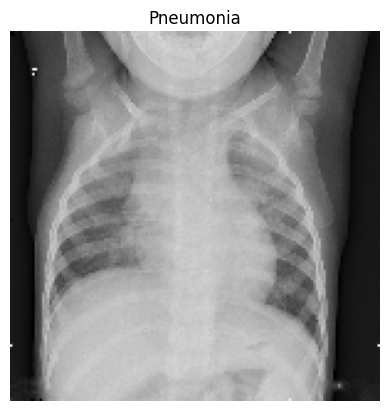

1/1 [==============================] - 0s 39ms/step
Probabilidades:
Normal: 17.48%
Pneumonia: 82.52%
Predicción: Pneumonia
1/1 [==============================] - 0s 33ms/step


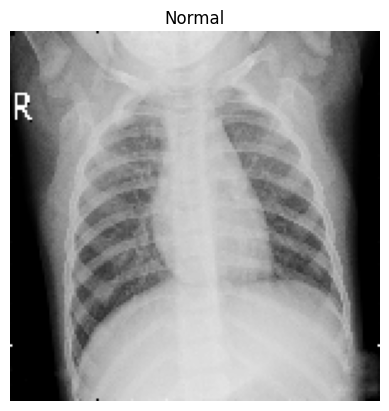

1/1 [==============================] - 0s 30ms/step
Probabilidades:
Normal: 97.08%
Pneumonia: 2.92%
Predicción: Normal
1/1 [==============================] - 0s 27ms/step


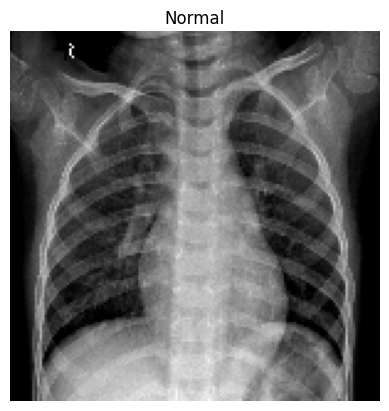

1/1 [==============================] - 0s 37ms/step
Probabilidades:
Normal: 91.03%
Pneumonia: 8.97%
Predicción: Normal
1/1 [==============================] - 0s 35ms/step


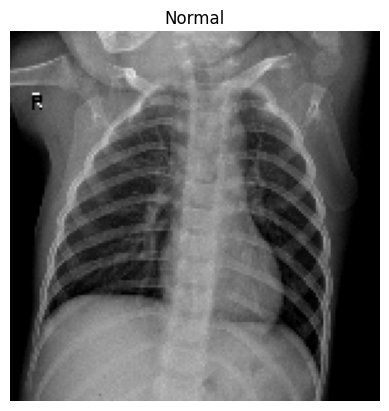

1/1 [==============================] - 0s 53ms/step
Probabilidades:
Normal: 96.12%
Pneumonia: 3.88%
Predicción: Normal


In [155]:
folder_path = './chest_xray/val/NORMAL/'
predict_folder(folder_path)

## Clasificador 2